## 前期准备

In [1]:
import numpy as np
import pandas as pd
import random
import torch
import torch.nn as nn
import torch.optim as optim  #一个实现了各种优化算法的库
from matplotlib import pyplot as plt
from tqdm import tqdm
from datetime import datetime
from sklearn.metrics import mean_squared_error
import warnings
import os

warnings.filterwarnings('ignore')

#设置随机种子
torch.backends.cudnn.deterministic = True  #将cudnn框架中的随机数生成器设为确定性模式
torch.backends.cudnn.benchmark = False  #关闭CuDNN框架的自动寻找最优卷积算法的功能，以避免不同的算法对结果产生影响
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

train_node = pd.read_csv("data/train_90.csv")
train_edge = pd.read_csv("data/edge_90.csv")
test_node = pd.read_csv("data/node_test_4_A.csv")
test_edge = pd.read_csv("data/edge_test_4_A.csv")
test_node_B = pd.read_csv("data/node_test_3_B.csv")
test_edge_B = pd.read_csv("data/edge_test_3_B.csv")

all_nodes = pd.concat([train_node, test_node], axis=0)
all_nodes = pd.concat([all_nodes, test_node_B], axis=0)
all_nodes = all_nodes.drop(["F_23", "F_27"], axis=1)
all_nodes = all_nodes.sort_values(["date_id", "geohash_id"]).reset_index(drop=True)
all_nodes.head()

,geohash_id,date_id,F_1,F_2,F_3,F_4,F_5,F_6,F_7,F_8,...,F_28,F_29,F_30,F_31,F_32,F_33,F_34,F_35,active_index,consume_index
0,007e3e4ef,20230104,-0.582,-0.592,-0.592,-0.480,-0.500,-0.562,0.066,0.113,...,0.101,0.301,0.009,-0.301,-0.350,-0.324,-0.314,-0.891,70.036,68.04
1,00a05f0b1,20230104,1.392,1.389,1.230,1.028,1.122,1.385,0.966,0.588,...,0.070,0.269,0.011,1.092,0.956,1.136,-0.206,0.412,74.135,78.88
2,00aaa190x,20230104,-0.904,-0.914,-0.992,-0.896,-0.911,-0.926,2.127,3.444,...,0.070,0.241,0.010,-0.600,-0.664,-0.579,-0.393,-0.888,66.727,58.93
3,00b24a1c9,20230104,-0.850,-0.839,-0.740,-0.854,-0.881,-0.911,0.822,2.162,...,0.061,0.315,0.008,-0.548,-0.614,-0.536,-1.088,-0.822,66.534,59.65
4,00f716fcd,20230104,-1.033,-1.079,-1.041,-0.987,-0.994,-1.030,0.875,0.989,...,0.049,0.180,0.008,-0.686,-0.731,-0.665,0.071,-0.747,78.696,52.51


In [2]:
all_nodes.tail()

,geohash_id,date_id,F_1,F_2,F_3,F_4,F_5,F_6,F_7,F_8,...,F_28,F_29,F_30,F_31,F_32,F_33,F_34,F_35,active_index,consume_index
110575,fee9ff61g,20230410,1.748,1.776,2.266,1.240,1.131,1.340,0.305,-0.014,...,0.067,0.370,0.019,1.555,1.417,1.081,-0.151,-0.734,NaN,NaN
110576,ff2a13239,20230410,-1.072,-1.123,-1.103,-1.018,-1.041,-1.064,0.112,-0.200,...,0.064,0.252,0.015,-0.701,-0.755,-0.679,-0.905,-2.637,NaN,NaN
110577,ff3efc8az,20230410,-0.656,-0.665,-0.706,-0.623,-0.612,-0.679,0.766,0.965,...,0.119,0.451,0.020,-0.207,-0.458,-0.284,-1.729,-1.150,NaN,NaN
110578,ff4566eeb,20230410,-0.556,-0.583,-0.568,-0.567,-0.597,-0.694,2.444,2.317,...,0.070,0.349,0.013,-0.281,-0.472,-0.356,-1.570,-1.334,NaN,NaN
110579,ffa6d8556,20230410,-1.115,-1.166,-1.144,-1.043,-1.064,-1.096,-1.965,-0.423,...,0.030,0.121,0.007,-0.732,-0.787,-0.700,-2.073,-2.658,NaN,NaN


In [3]:
train_edge = pd.read_csv("data/edge_90.csv")
test_edge = pd.read_csv("data/edge_test_4_A.csv")
test_B_edge = pd.read_csv("data/edge_test_3_B.csv")
all_edges = pd.concat([train_edge, test_edge], axis=0)
all_edges = pd.concat([all_edges, test_B_edge], axis=0)
all_edges = all_edges.sort_values(["date_id", "geohash6_point1", "geohash6_point2"]).reset_index(drop=True)

set_train = list(np.sort(all_nodes['geohash_id'].unique()))
judge = all_edges["geohash6_point1"].isin(set_train) & all_edges["geohash6_point2"].isin(set_train)
all_edges = all_edges.loc[judge, :].reset_index(drop=True)
all_edges["F1-F2"] = all_edges["F_1"] - all_edges["F_2"]
all_edges["abs(F1-F2)"] = all_edges["F1-F2"].abs()
all_edges

,geohash6_point1,geohash6_point2,F_1,F_2,date_id,F1-F2,abs(F1-F2)
0,007e3e4ef,5ee4659fj,3,47,20230104,-44,44
1,007e3e4ef,95f72a4dv,1,21,20230104,-20,20
2,007e3e4ef,c9d352c0w,2,27,20230104,-25,25
3,00a05f0b1,07a98d7fr,2,36,20230104,-34,34
4,00a05f0b1,0c95ac0bp,1,36,20230104,-35,35
...,...,...,...,...,...,...,...
1177934,ff4566eeb,c9d352c0w,2,16,20230410,-14,14
1177935,ff4566eeb,dd186b700,6,37,20230410,-31,31
1177936,ff4566eeb,edd6ac62u,8,21,20230410,-13,13
1177937,ff4566eeb,f672b141p,7,23,20230410,-16,16


## 特征工程

In [4]:
def feature_processing(all_nodes, all_edges):
    # 1. 日期特征
    all_nodes['date_id'] = pd.to_datetime(all_nodes['date_id'], format="%Y%m%d")
    all_edges['date_id'] = pd.to_datetime(all_nodes['date_id'], format="%Y%m%d")
    all_nodes['is_weekday'] = all_nodes['date_id'].apply(lambda x: 1 if x.weekday() < 5 else 0)
    all_nodes['weekday_temp'] = all_nodes['date_id'].dt.day_name()
    one_hot_encoded = pd.get_dummies(all_nodes['weekday_temp'], prefix='is')
    all_nodes = pd.concat([all_nodes.drop('weekday_temp', axis=1), one_hot_encoded], axis=1)

    # 2. 差分特征
    for feature in init_features:
        all_nodes[f"{feature}_diff"] = all_nodes.groupby('geohash_id')[feature].diff().fillna(0)

    # 3. 滑动窗口特征
    window_size = [4, 7]
    for feature in tqdm(init_features):
        for window in window_size:
            for func in ['mean', 'std']:
                all_nodes[f"{feature}_{window}_{func}"] = all_nodes.groupby('geohash_id')[feature].rolling(
                    window=window, min_periods=1).agg(func).reset_index(0, drop=True).fillna(0)

    # 4. 边特征
    point1 = all_edges.groupby(["date_id", "geohash6_point1"])[['F_1', 'F_2', 'F1-F2']].agg(
        ['max', 'min', 'mean', 'std']).reset_index()
    point1.columns = ["".join(x) for x in point1.columns.ravel()]
    point2 = all_edges.groupby(["date_id", "geohash6_point2"])[['F_1', 'F_2', 'F1-F2']].agg(
        ['max', 'min', 'mean', 'std']).reset_index()
    point2.columns = ["".join(x) for x in point2.columns.ravel()]
    all_nodes = pd.merge(all_nodes, point1, how='outer', left_on=["date_id", "geohash_id"],
                         right_on=["date_id", "geohash6_point1"]).drop("geohash6_point1", axis=1)
    all_nodes = pd.merge(all_nodes, point2, how='outer', left_on=["date_id", "geohash_id"],
                         right_on=["date_id", "geohash6_point2"]).drop("geohash6_point2", axis=1)
    all_nodes = all_nodes.fillna(0)
    return all_nodes

In [5]:
%%time
init_features = [f"F_{i}" for i in range(1, 36) if i not in [23, 27]]
file_path = r"all_nodes_B.csv"

if os.path.isfile(file_path):
    print("file exist!")
    all_nodes = pd.read_csv(file_path)
else:
    print("file need processing!")
    all_nodes = feature_processing(all_nodes, all_edges)
    all_nodes.to_csv(file_path, index=None)

proc_features = [feat for feat in all_nodes.columns if
                 feat not in ['geohash_id', 'date_id', 'active_index', 'consume_index', 'F_23', 'F_27'] + init_features]
all_features = init_features + proc_features
all_nodes

file need processing!


100%|██████████| 33/33 [00:05<00:00,  6.45it/s]


CPU times: total: 6.64 s
Wall time: 19 s


,geohash_id,date_id,F_1,F_2,F_3,F_4,F_5,F_6,F_7,F_8,...,F_1mean_y,F_1std_y,F_2max_y,F_2min_y,F_2mean_y,F_2std_y,F1-F2max_y,F1-F2min_y,F1-F2mean_y,F1-F2std_y
0,007e3e4ef,2023-01-04,-0.582,-0.592,-0.592,-0.480,-0.500,-0.562,0.066,0.113,...,1.000000,0.000000,39.0,20.0,29.5,13.435029,-19.0,-38.0,-28.500000,13.435029
1,00a05f0b1,2023-01-04,1.392,1.389,1.230,1.028,1.122,1.385,0.966,0.588,...,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000
2,00aaa190x,2023-01-04,-0.904,-0.914,-0.992,-0.896,-0.911,-0.926,2.127,3.444,...,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000
3,00b24a1c9,2023-01-04,-0.850,-0.839,-0.740,-0.854,-0.881,-0.911,0.822,2.162,...,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000
4,00f716fcd,2023-01-04,-1.033,-1.079,-1.041,-0.987,-0.994,-1.030,0.875,0.989,...,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110575,fee9ff61g,2023-04-10,1.748,1.776,2.266,1.240,1.131,1.340,0.305,-0.014,...,20.333333,26.857649,33.0,10.0,23.0,11.789826,41.0,-25.0,-2.666667,37.819748
110576,ff2a13239,2023-04-10,-1.072,-1.123,-1.103,-1.018,-1.041,-1.064,0.112,-0.200,...,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000
110577,ff3efc8az,2023-04-10,-0.656,-0.665,-0.706,-0.623,-0.612,-0.679,0.766,0.965,...,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000
110578,ff4566eeb,2023-04-10,-0.556,-0.583,-0.568,-0.567,-0.597,-0.694,2.444,2.317,...,12.000000,0.000000,48.0,48.0,48.0,0.000000,-36.0,-36.0,-36.000000,0.000000


## 模型建立

### 数据预处理

#### 类别特征编码

In [6]:
set_train = list(np.sort(all_nodes['geohash_id'].unique()))
set_map = {}
for index, i in enumerate(set_train):
    set_map[i] = index
all_nodes['geohash_id'] = all_nodes['geohash_id'].map(set_map)
all_nodes

,geohash_id,date_id,F_1,F_2,F_3,F_4,F_5,F_6,F_7,F_8,...,F_1mean_y,F_1std_y,F_2max_y,F_2min_y,F_2mean_y,F_2std_y,F1-F2max_y,F1-F2min_y,F1-F2mean_y,F1-F2std_y
0,0,2023-01-04,-0.582,-0.592,-0.592,-0.480,-0.500,-0.562,0.066,0.113,...,1.000000,0.000000,39.0,20.0,29.5,13.435029,-19.0,-38.0,-28.500000,13.435029
1,1,2023-01-04,1.392,1.389,1.230,1.028,1.122,1.385,0.966,0.588,...,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000
2,2,2023-01-04,-0.904,-0.914,-0.992,-0.896,-0.911,-0.926,2.127,3.444,...,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000
3,3,2023-01-04,-0.850,-0.839,-0.740,-0.854,-0.881,-0.911,0.822,2.162,...,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000
4,4,2023-01-04,-1.033,-1.079,-1.041,-0.987,-0.994,-1.030,0.875,0.989,...,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110575,1135,2023-04-10,1.748,1.776,2.266,1.240,1.131,1.340,0.305,-0.014,...,20.333333,26.857649,33.0,10.0,23.0,11.789826,41.0,-25.0,-2.666667,37.819748
110576,1136,2023-04-10,-1.072,-1.123,-1.103,-1.018,-1.041,-1.064,0.112,-0.200,...,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000
110577,1137,2023-04-10,-0.656,-0.665,-0.706,-0.623,-0.612,-0.679,0.766,0.965,...,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000
110578,1138,2023-04-10,-0.556,-0.583,-0.568,-0.567,-0.597,-0.694,2.444,2.317,...,12.000000,0.000000,48.0,48.0,48.0,0.000000,-36.0,-36.0,-36.000000,0.000000


#### 数据标准化

In [7]:
### F1~F35不标准化
from sklearn.preprocessing import StandardScaler

scaler_x = StandardScaler()
all_nodes.loc[:, proc_features] = scaler_x.fit_transform(all_nodes.loc[:, proc_features])
all_nodes

,geohash_id,date_id,F_1,F_2,F_3,F_4,F_5,F_6,F_7,F_8,...,F_1mean_y,F_1std_y,F_2max_y,F_2min_y,F_2mean_y,F_2std_y,F1-F2max_y,F1-F2min_y,F1-F2mean_y,F1-F2std_y
0,0,2023-01-04,-0.582,-0.592,-0.592,-0.480,-0.500,-0.562,0.066,0.113,...,-0.113598,-0.096712,1.245980,0.646512,1.040350,1.502895,-0.139521,-0.163076,-0.164838,-0.050449
1,1,2023-01-04,1.392,1.389,1.230,1.028,1.122,1.385,0.966,0.588,...,-0.116802,-0.096712,-0.914164,-0.759979,-0.896432,-0.499454,-0.100419,-0.019736,-0.073251,-0.103653
2,2,2023-01-04,-0.904,-0.914,-0.992,-0.896,-0.911,-0.926,2.127,3.444,...,-0.116802,-0.096712,-0.914164,-0.759979,-0.896432,-0.499454,-0.100419,-0.019736,-0.073251,-0.103653
3,3,2023-01-04,-0.850,-0.839,-0.740,-0.854,-0.881,-0.911,0.822,2.162,...,-0.116802,-0.096712,-0.914164,-0.759979,-0.896432,-0.499454,-0.100419,-0.019736,-0.073251,-0.103653
4,4,2023-01-04,-1.033,-1.079,-1.041,-0.987,-0.994,-1.030,0.875,0.989,...,-0.116802,-0.096712,-0.914164,-0.759979,-0.896432,-0.499454,-0.100419,-0.019736,-0.073251,-0.103653
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110575,1135,2023-04-10,1.748,1.776,2.266,1.240,1.131,1.340,0.305,-0.014,...,-0.051641,0.009651,0.913650,-0.056733,0.613601,1.257695,-0.016041,-0.114039,-0.081820,0.046115
110576,1136,2023-04-10,-1.072,-1.123,-1.103,-1.018,-1.041,-1.064,0.112,-0.200,...,-0.116802,-0.096712,-0.914164,-0.759979,-0.896432,-0.499454,-0.100419,-0.019736,-0.073251,-0.103653
110577,1137,2023-04-10,-0.656,-0.665,-0.706,-0.623,-0.612,-0.679,0.766,0.965,...,-0.116802,-0.096712,-0.914164,-0.759979,-0.896432,-0.499454,-0.100419,-0.019736,-0.073251,-0.103653
110578,1138,2023-04-10,-0.556,-0.583,-0.568,-0.567,-0.597,-0.694,2.444,2.317,...,-0.078347,-0.096712,1.744475,2.615600,2.254941,-0.499454,-0.174506,-0.155532,-0.188940,-0.103653


### 创建dataset

In [8]:
from torch.utils.data import Dataset, DataLoader


#组织为1140个97*特征维数的数据集
class DayDataset(Dataset):
    def __init__(self, data, days, window_size):
        # 总数 * 特征维数
        self.data = data.sort_values(["geohash_id", "date_id"])
        self.features = torch.tensor(self.data[["geohash_id"] + all_features].values, dtype=torch.float32)
        self.labels = torch.tensor(self.data[["active_index", "consume_index"]].values, dtype=torch.float32)

        #将tensor转化为1140 * 天数 * 特征维数
        self.features_stack = torch.stack([self.features[i:i + days] for i in range(0, self.features.shape[0], days)])
        self.labels_stack = torch.stack([self.labels[i:i + days] for i in range(0, self.labels.shape[0], days)])

        #转化为81个1140 * 14 * 特征维数
        step = 1
        self.data_list = []
        self.label_list = []
        for i in range(0, 97 - window_size + 1, step):
            data_temp = self.features_stack[:, i:i + window_size, :]
            label_temp = self.labels_stack[:, i:i + window_size, :]
            self.data_list.append(data_temp)
            self.label_list.append(label_temp)

        #转化为81*1140，14，特征维数
        self.train = torch.cat(self.data_list[:-7], dim=0)
        self.test = torch.cat(self.data_list[-3:], dim=0)

        self.labels = torch.cat(self.label_list[:-7], dim=0)

    def __getitem__(self, index):
        return self.train[index, :, :], self.labels[index, :, :]

    def __len__(self):
        return self.train.shape[0]


my_dataset = DayDataset(all_nodes, 97, 14)

In [9]:
my_dataset.test.shape

torch.Size([3420, 14, 231])

In [10]:
#检查标签是否正确
sum = 0
for index, i in enumerate(my_dataset.label_list):
    has_nan = torch.isnan(i)
    if torch.any(has_nan).item():
        print(index)
        sum += 1
sum

0

### 网络搭建

### CNN

In [11]:
class CNN(nn.Module):
    def __init__(self, input_size, class_size, hidden_size, num_layers):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv1d(in_channels=input_size, out_channels=64, kernel_size=2),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Conv1d(in_channels=64, out_channels=hidden_size, kernel_size=2),
            nn.ReLU()
        )
        self.conv2 = nn.Sequential(nn.Conv1d(in_channels=input_size, out_channels=hidden_size, kernel_size=1))
        self.init_linear = nn.Linear(class_size, 64)
        self.lstm = nn.LSTM(hidden_size, hidden_size, num_layers, batch_first=True, dropout=0.5)
        self.embedding = nn.Embedding(1140, 10)
        self.linear1 = nn.Sequential(
            nn.Linear(1664, 32),
            nn.Linear(32, 1)
        )
        self.linear2 = nn.Sequential(
            nn.Linear(1664, 32),
            nn.Linear(32, 1)
        )

    def forward(self, x):  # batch * 14 * 207
        ## 处理类别特征
        x_c = x[:, :, 0].long()
        x_c = self.embedding(x_c)  # batch * 14 * 10
        x = torch.cat([x_c, x[:, :, 1:]], dim=2)  # batch * 14 * 207-1+10
        #print(x.shape)

        x1 = x.permute(0, 2, 1)  # batch * 216 * 14
        x1 = self.conv1(x1)  # batch * 64  * 12   卷积核size为2说明在14天以每相邻两天为核，得到12个特征

        x2 = x.permute(0, 2, 1)  # batch * 216 * 14
        x2 = self.conv2(x2)  # batch * 64  * 14

        x3 = torch.cat([x1, x2], dim=2)  # batch * 64 * 26
        x3 = x3.reshape(x3.shape[0], -1)  # batch * 1664

        # x = x.permute(0,2,1)  # batch * 12 * 64
        # x, _ = self.lstm(x)   # batch * 12 * 64
        # x = x[:,-1,:]         # batch * 64

        x_active = self.linear1(x3)  # 得到1天的active预测结果
        x_consume = self.linear2(x3)  # 得到1天的consume预测结果

        return torch.cat([x_active, x_consume], dim=1)


class_size = 43  #原始特征数量，33 + 10
input_size = 207 - 1 + 10  #总特征数
hidden_size = 64
num_layers = 2
model = CNN(input_size, class_size, hidden_size, num_layers)
shape = (64, 14, 207)
x = torch.randint(0, 1024, shape)
output = model(x)
output.shape

torch.Size([64, 2])

#### CNN训练

In [12]:
from torch.utils.data.dataset import random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau

##超参数设置
class_size = 43  # 类别特征
input_size = 231 - 1 + 10  # 特征维度
hidden_size = 64  # 可以根据实际情况调整
num_layers = 2
batch_size = 64

##模型调整
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN(input_size, class_size, hidden_size, num_layers).to(device)
num_epochs = 200
optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.5, 0.999))
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=4, verbose=True)
criterion = nn.MSELoss()

##数据组织
my_dataset = DayDataset(all_nodes, 97, 14)
train_size = int(0.8 * len(my_dataset))
val_size = len(my_dataset) - train_size

train_dataset, val_dataset = random_split(my_dataset, [train_size, val_size])
train_loader, val_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True), DataLoader(val_dataset,
                                                                                                      batch_size=batch_size,
                                                                                                      shuffle=True)

In [13]:
len(train_dataset), len(val_dataset), len(train_loader), len(val_loader)

(70224, 17556, 1098, 275)

In [14]:
next(iter(train_loader))[0].shape

torch.Size([64, 14, 231])

In [15]:
output

tensor([[ 52.2538,  61.8222],
        [ 95.2515, 122.9317],
        [119.8708, 102.5638],
        [118.4260,  87.0681],
        [154.8870, 122.7690],
        [ 59.9093, 196.9474],
        [ 28.0710, 103.7866],
        [ 76.8084, 147.5471],
        [ 87.9055, 106.6543],
        [112.2685, 126.9071],
        [ 17.5610, 214.0840],
        [ 61.8440, 156.7495],
        [ 64.6358, 132.2232],
        [ 74.4922, 191.0642],
        [ 62.7003, 163.3676],
        [ 62.4738, 105.2073],
        [156.8747, 143.9776],
        [ 28.8233, 143.5929],
        [ 94.0079,  72.2786],
        [ 37.3318, 140.2298],
        [ 71.3870,  99.5455],
        [ 97.3093,  90.7723],
        [129.1301, 165.1569],
        [ 28.1726, 185.8520],
        [ 76.3485, 137.5963],
        [121.1125, 109.3302],
        [107.4851,  64.1659],
        [127.4023,  71.4265],
        [ 12.6730,  63.7823],
        [ 79.5080, 165.5534],
        [ 24.3060, 152.9968],
        [ 80.6626,  95.1842],
        [ 38.1869,  72.6319],
        [ 

In [16]:
# temp = next((iter(train_loader)))
# temp_data,temp_label = temp[0],temp[1]
# temp_data.shape,temp_label.shape

In [17]:
best_dict = {}
for epoch in tqdm(range(num_epochs)):
    model.train()
    train_losses = []
    for index, (input, label) in enumerate(train_loader):
        input = input.to(device)
        label = torch.squeeze(label[:, -1:, ]).to(device)
        output = model(input)
        train_loss = criterion(output, label)
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
        train_losses.append(train_loss.item())

    if epoch % 5 == 4:
        model.eval()
        torch.save(model.state_dict(), f'model/model_params_{epoch}.pth')
        val_losses = []
        outputs, labels = [], []
        for index, (input, label) in enumerate(val_loader):
            input = input.to(device)
            label = torch.squeeze(label[:, -1:, ]).to(device)
            output = model(input)

            outputs.append(output)
            labels.append(label)
            val_loss = criterion(output, label)
            score = 1 / (1 + val_loss.item())
            val_losses.append(val_loss.item())

        ## 计算此次验证分数
        with torch.no_grad():
            all_outputs = torch.cat(outputs, dim=0)
            all_labels = torch.cat(labels, dim=0)
            rmse = torch.sqrt(criterion(all_outputs, all_labels)).item()
            score = 1 / (1 + rmse)

        scheduler.step(rmse)
        best_dict[epoch] = score
        print('epoch {:03d} train_loss {:.8f} val_loss {:.8f} score {:.3f}'.format(epoch, np.mean(train_losses),
                                                                                   np.mean(val_losses), score))

  2%|▎         | 5/200 [00:19<12:06,  3.73s/it]

epoch 004 train_loss 3.34249728 val_loss 2.76619068 score 0.375


  5%|▌         | 10/200 [00:36<10:51,  3.43s/it]

epoch 009 train_loss 2.05173470 val_loss 1.19528913 score 0.478


  8%|▊         | 15/200 [00:52<09:58,  3.24s/it]

epoch 014 train_loss 1.58504166 val_loss 1.91742638 score 0.419


 10%|█         | 20/200 [01:08<09:55,  3.31s/it]

epoch 019 train_loss 1.05220798 val_loss 2.41271449 score 0.392


 12%|█▎        | 25/200 [01:23<09:12,  3.16s/it]

epoch 024 train_loss 0.65066596 val_loss 0.68279465 score 0.548


 15%|█▌        | 30/200 [01:43<10:38,  3.76s/it]

epoch 029 train_loss 0.59187282 val_loss 0.62112051 score 0.559


 18%|█▊        | 35/200 [02:01<10:09,  3.69s/it]

epoch 034 train_loss 0.59751686 val_loss 0.45103965 score 0.598


 20%|██        | 40/200 [02:18<09:24,  3.53s/it]

epoch 039 train_loss 0.41826554 val_loss 0.74586875 score 0.537


 22%|██▎       | 45/200 [02:35<09:04,  3.52s/it]

epoch 044 train_loss 0.43594926 val_loss 1.04908642 score 0.494


 25%|██▌       | 50/200 [02:53<08:48,  3.52s/it]

epoch 049 train_loss 0.42718486 val_loss 1.16437756 score 0.482


 28%|██▊       | 55/200 [03:10<08:33,  3.54s/it]

epoch 054 train_loss 0.39479710 val_loss 0.38839306 score 0.616


 30%|███       | 60/200 [03:27<08:09,  3.50s/it]

epoch 059 train_loss 0.36766370 val_loss 0.37234707 score 0.621


 32%|███▎      | 65/200 [03:44<07:45,  3.45s/it]

epoch 064 train_loss 0.33206509 val_loss 0.60559469 score 0.562


 35%|███▌      | 70/200 [04:01<07:23,  3.41s/it]

epoch 069 train_loss 0.28062638 val_loss 0.44268429 score 0.600


 38%|███▊      | 75/200 [04:18<07:31,  3.61s/it]

epoch 074 train_loss 0.31821024 val_loss 0.35116388 score 0.628


 40%|████      | 80/200 [04:34<06:23,  3.20s/it]

epoch 079 train_loss 0.28133549 val_loss 0.21025516 score 0.686


 42%|████▎     | 85/200 [04:49<06:01,  3.15s/it]

epoch 084 train_loss 0.29076134 val_loss 0.26206448 score 0.661


 45%|████▌     | 90/200 [05:08<07:02,  3.84s/it]

epoch 089 train_loss 0.22747307 val_loss 0.26917959 score 0.658


 48%|████▊     | 95/200 [05:26<06:14,  3.57s/it]

epoch 094 train_loss 0.25933861 val_loss 0.87456313 score 0.517


 50%|█████     | 100/200 [05:42<05:30,  3.30s/it]

epoch 099 train_loss 0.22538189 val_loss 0.20949079 score 0.686


 52%|█████▎    | 105/200 [05:58<05:09,  3.26s/it]

epoch 104 train_loss 0.20449763 val_loss 0.20288382 score 0.689


 55%|█████▌    | 110/200 [06:14<04:51,  3.24s/it]

epoch 109 train_loss 0.21491537 val_loss 0.25925705 score 0.663


 57%|█████▊    | 115/200 [06:30<04:35,  3.25s/it]

epoch 114 train_loss 0.16521528 val_loss 0.25910711 score 0.663


 60%|██████    | 120/200 [06:46<04:20,  3.25s/it]

epoch 119 train_loss 0.21126290 val_loss 0.26619458 score 0.660


 62%|██████▎   | 125/200 [07:01<03:57,  3.17s/it]

epoch 124 train_loss 0.23067804 val_loss 0.36373887 score 0.624


 65%|██████▌   | 130/200 [07:17<03:46,  3.24s/it]

epoch 129 train_loss 0.15165120 val_loss 0.20031057 score 0.691


 68%|██████▊   | 135/200 [07:34<03:47,  3.49s/it]

epoch 134 train_loss 0.18423145 val_loss 0.34805593 score 0.629


 70%|███████   | 140/200 [07:52<03:35,  3.60s/it]

epoch 139 train_loss 0.20145357 val_loss 0.19680018 score 0.693


 72%|███████▎  | 145/200 [08:11<03:36,  3.94s/it]

epoch 144 train_loss 0.18542970 val_loss 0.23807014 score 0.672


 75%|███████▌  | 150/200 [08:31<03:24,  4.09s/it]

epoch 149 train_loss 0.16711780 val_loss 0.24307013 score 0.670


 78%|███████▊  | 155/200 [08:51<03:02,  4.06s/it]

epoch 154 train_loss 0.55532616 val_loss 0.19141508 score 0.697


 80%|████████  | 160/200 [09:08<02:24,  3.62s/it]

epoch 159 train_loss 0.15079689 val_loss 0.25832788 score 0.663


 82%|████████▎ | 165/200 [09:26<02:05,  3.57s/it]

epoch 164 train_loss 0.14973792 val_loss 0.40172069 score 0.612


 85%|████████▌ | 170/200 [09:43<01:44,  3.48s/it]

epoch 169 train_loss 0.32502509 val_loss 0.14952264 score 0.721


 88%|████████▊ | 175/200 [09:59<01:24,  3.37s/it]

epoch 174 train_loss 0.14971559 val_loss 0.25348700 score 0.666


 90%|█████████ | 180/200 [10:15<01:04,  3.25s/it]

epoch 179 train_loss 0.13651851 val_loss 0.16195012 score 0.713


 92%|█████████▎| 185/200 [10:31<00:47,  3.19s/it]

epoch 184 train_loss 0.12980799 val_loss 0.15396302 score 0.718


 95%|█████████▌| 190/200 [10:47<00:31,  3.19s/it]

epoch 189 train_loss 0.44755427 val_loss 0.43979537 score 0.601


 98%|█████████▊| 195/200 [11:03<00:16,  3.37s/it]

Epoch 00039: reducing learning rate of group 0 to 2.0000e-04.
epoch 194 train_loss 0.14276822 val_loss 0.39542843 score 0.614


100%|██████████| 200/200 [11:20<00:00,  3.40s/it]

epoch 199 train_loss 0.05229227 val_loss 0.14615753 score 0.724


In [18]:
#gpu count
print(torch.cuda.device_count())
import joblib

joblib.cpu_count()

1


32

#### 可视化训练结果

In [19]:
max_score = max(best_dict.values())
found_keys = [key for key, value in best_dict.items() if value == max_score]
print(max_score, found_keys)

0.7243075422813455 [199]


In [20]:
best_dict  #加了embedding，0.00278

{4: 0.3754006523030982,
 9: 0.47755456952099645,
 14: 0.4192822675748658,
 19: 0.3916615747660111,
 24: 0.5475691694947749,
 29: 0.5591938779241186,
 34: 0.5982754327349266,
 39: 0.5365162447173322,
 44: 0.49400828693605914,
 49: 0.48156519158309397,
 54: 0.616021312146321,
 59: 0.6209197636323571,
 64: 0.5623880693875436,
 69: 0.6004310865765959,
 74: 0.6279072570054154,
 79: 0.6855286847688393,
 84: 0.6614734617598587,
 89: 0.6583305107012548,
 94: 0.5174579592025569,
 99: 0.6858503058692733,
 104: 0.6892850909003809,
 109: 0.6629328686079782,
 114: 0.6626302182741479,
 119: 0.65957533047829,
 124: 0.6237938387348045,
 129: 0.6907152588222124,
 134: 0.6288564282321828,
 139: 0.6928985789732212,
 144: 0.6720182832122645,
 149: 0.669905947845317,
 154: 0.6967625420263112,
 159: 0.662966504756922,
 164: 0.6119724892051733,
 169: 0.7210384797384972,
 174: 0.6660936569539946,
 179: 0.7129370313708865,
 184: 0.7180327602241422,
 189: 0.6014907687036949,
 194: 0.6138815353785616,
 199: 0.72

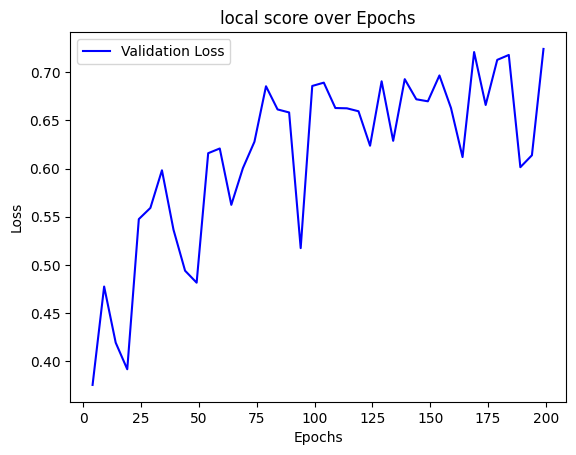

In [21]:
import matplotlib.pyplot as plt

x = list(best_dict.keys())
y = list(best_dict.values())

plt.plot(x, y, 'b-', label='Validation Loss')
plt.title('local score over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#### CNN预测

In [22]:
test_model = CNN(input_size, class_size, hidden_size, num_layers).to(device)
#min_index = list(best_dict.values()).index(min(best_dict.values()))
max_index = 19
print(max_index)
test_model.load_state_dict(torch.load(f'model/model_params_{max_index}9.pth'))

19


<All keys matched successfully>

In [23]:
1140 * 3

3420

In [24]:
my_dataset.test[-1, -1]

tensor([ 1.1390e+03, -1.1150e+00, -1.1660e+00, -1.1440e+00, -1.0430e+00,
        -1.0640e+00, -1.0960e+00, -1.9650e+00, -4.2300e-01, -7.8000e-01,
         2.8860e+00,  4.6410e+00, -1.9230e+00, -3.1520e+00, -1.4010e+00,
        -3.5500e-01,  1.5000e+00,  2.0330e+00, -2.1310e+00,  4.6500e-01,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  2.4100e-01,  1.8200e-01,
         9.5000e-02,  3.0000e-02,  1.2100e-01,  7.0000e-03, -7.3200e-01,
        -7.8700e-01, -7.0000e-01, -2.0730e+00, -2.6580e+00,  6.3702e-01,
        -4.1070e-01,  2.4349e+00, -4.1070e-01, -4.1070e-01, -4.1070e-01,
        -3.9340e-01, -4.1070e-01, -1.6835e-02, -1.7972e-02, -2.6495e-02,
        -2.1941e-02, -3.8908e-02, -1.1668e-02, -2.5393e+00, -1.7358e+00,
        -1.1224e-01,  4.1495e-01, -3.3580e+00, -1.5823e+00, -4.4265e+00,
        -2.2823e+00, -1.0228e-02, -6.7745e-01, -1.6725e+00, -1.7999e-01,
        -1.1053e+00, -3.8471e-02, -7.5676e-02, -6.1228e-02, -2.0821e+00,
        -9.5540e+00, -1.5407e+00, -4.8378e-01, -7.4

In [25]:
all_nodes.iloc[-1]

geohash_id                    1139
date_id        2023-04-10 00:00:00
F_1                         -1.115
F_2                         -1.166
F_3                         -1.144
                      ...         
F_2std_y                 -0.499454
F1-F2max_y               -0.100419
F1-F2min_y               -0.019736
F1-F2mean_y              -0.073251
F1-F2std_y               -0.103653
Name: 110579, Length: 234, dtype: object

In [26]:
test_model.eval()
batch_list = list(range(0, 3420, batch_size))
test = my_dataset.test.to(device)
output_list = []

for i in range(len(batch_list)):
    if i != len(batch_list) - 1:
        x = test[batch_list[i]:batch_list[i + 1], :, :]
    else:
        x = test[batch_list[i]:, :, :]

    output = model(x)
    output_list.append(output)
output.shape

torch.Size([28, 2])

#### 生成提交结果

In [27]:
new = torch.cat(output_list, dim=0).cpu().detach().numpy()
all_nodes['date_id'] = pd.to_datetime(all_nodes['date_id'], format="%Y-%m-%d")
all_nodes.loc[
    (all_nodes['date_id'] >= datetime(2023, 4, 8)) & (all_nodes['date_id'] <= datetime(2023, 4, 10)), ["active_index",
                                                                                                       "consume_index"]] = new

In [28]:
submit = all_nodes.loc[
    (all_nodes['date_id'] >= datetime(2023, 4, 8)) & (all_nodes['date_id'] <= datetime(2023, 4, 10)), ["geohash_id",
                                                                                                       "date_id",
                                                                                                       "active_index",
                                                                                                       "consume_index"]].copy().reset_index(
    drop=True)
submit = submit.loc[:, ["geohash_id", "consume_index", "active_index", "date_id"]]
submit['date_id'] = submit['date_id'].apply(lambda x: x.strftime('%Y%m%d'))
submit = submit.rename(columns={'consume_index': 'consumption_level', 'active_index': 'activity_level'})
swapped_dict = {v: k for k, v in set_map.items()}
submit["geohash_id"] = submit["geohash_id"].map(swapped_dict)
submit

,geohash_id,consumption_level,activity_level,date_id
0,007e3e4ef,68.555862,71.032188,20230408
1,00a05f0b1,72.959862,72.190453,20230408
2,00aaa190x,56.708282,66.435692,20230408
3,00b24a1c9,58.621490,66.659218,20230408
4,00f716fcd,51.771442,63.668507,20230408
...,...,...,...,...
3415,fee9ff61g,78.110649,70.986977,20230410
3416,ff2a13239,44.967850,56.458126,20230410
3417,ff3efc8az,65.500214,70.046112,20230410
3418,ff4566eeb,64.773674,69.397804,20230410


In [29]:
submit.to_csv('submit/submit_B.csv', sep='\t', index=None)